In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt


In [ ]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

tmp_real=sum(raw_data_channel_0.real)/len(raw_data_channel_0)
tmp_img= sum(raw_data_channel_0.imag)/len(raw_data_channel_0)
raw_data_channel_0=raw_data_channel_0-complex(tmp_real,tmp_img)

![Screen Shot 2023-08-25 at 10.26.19 AM.png](<attachment:Screen Shot 2023-08-25 at 10.26.19 AM.png>)
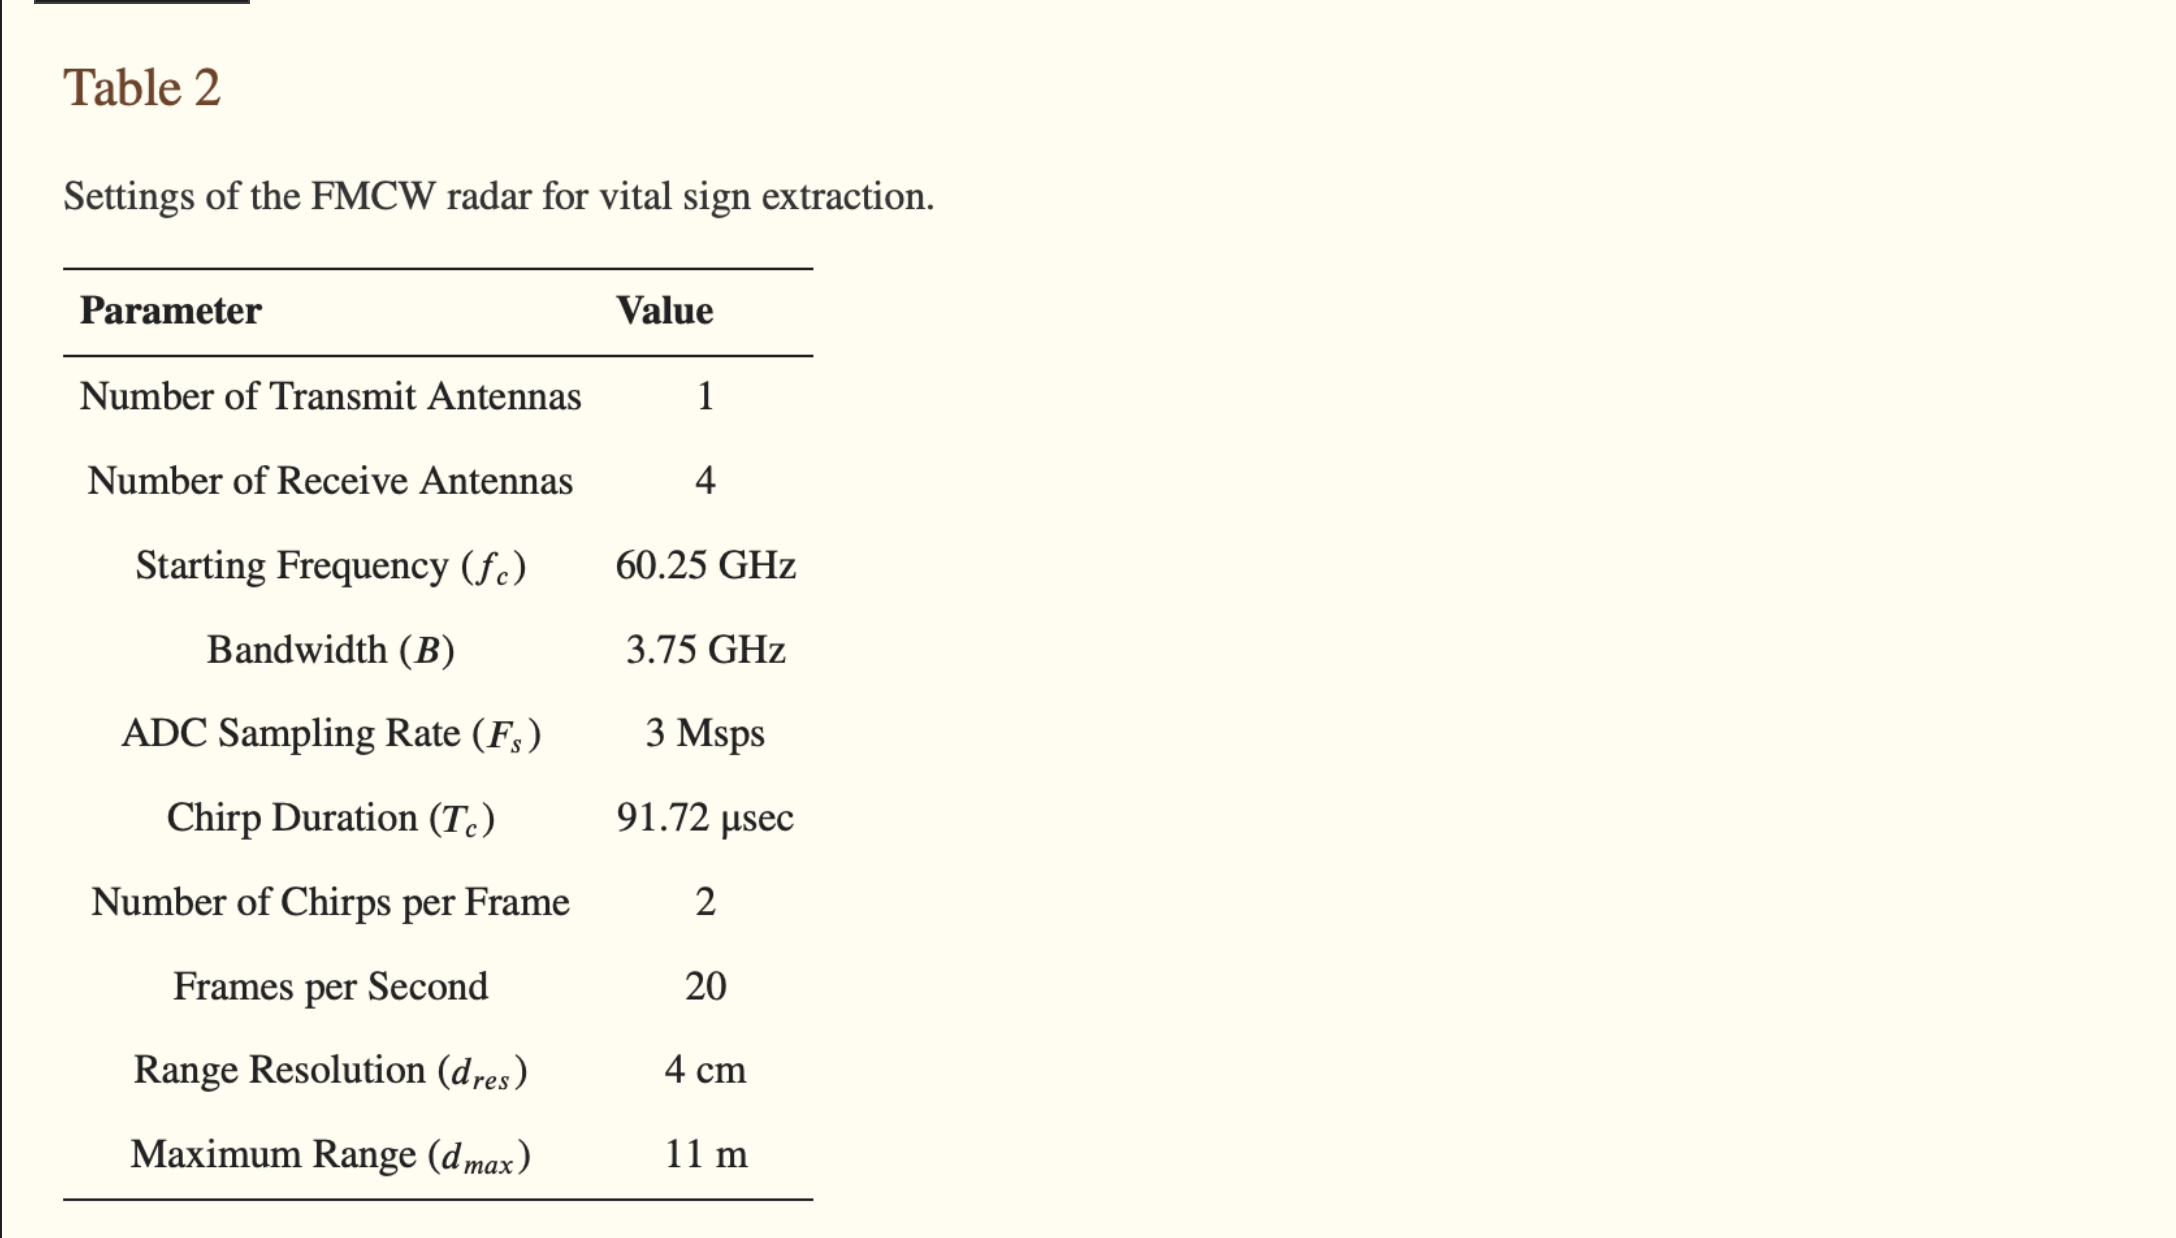

In [ ]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [ ]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP]
          for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP)]

first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 2)]
print(np.array(first_chirps_of_frame).shape)


In [ ]:
fft_chirps = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitude_spectrums = [np.abs(fft_chirp) for fft_chirp in fft_chirps]

In [ ]:
x= np.arange(0,11,11/len(magnitude_spectrums[0]))
plt.plot(x,magnitude_spectrums[0])
plt.plot(x,magnitude_spectrums[2010])
plt.xlabel('meters')
plt.ylabel('Amplitude')
plt.show()

In [ ]:

#find it's manitude
magnitude_index = np.zeros(shape=len(magnitude_spectrums))
for  magnitude_spectrum in magnitude_spectrums:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[1:-1])
    magnitude_index[max_index]+=1
bin_of_interest = np.argmax(magnitude_index)
print("bin_of_interest:",bin_of_interest)
for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)

In [ ]:
tmp_array= copy.deepcopy(magnitude_spectrums)
for tmp in tmp_array:
    tmp[bin_of_interest]=80000



plt.figure(figsize=(12, 6))
xmin=0
xmax=11
x = np.linspace(xmin, xmax, 15)
ymin=0
ymax=len(tmp_array)/20 #6000 chirp ~6000 frame each second has 20 frame -> second
#ymax ~300s ~5mins
print(ymax)
y = np.linspace(ymin, ymax, 30)
plt.xticks(x)
plt.yticks(y)

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('cm')
plt.ylabel('second')
plt.colorbar()
plt.show()


TypeError: apply_filter() missing 2 required positional arguments: 'plot_screen_count' and 'plot_index'

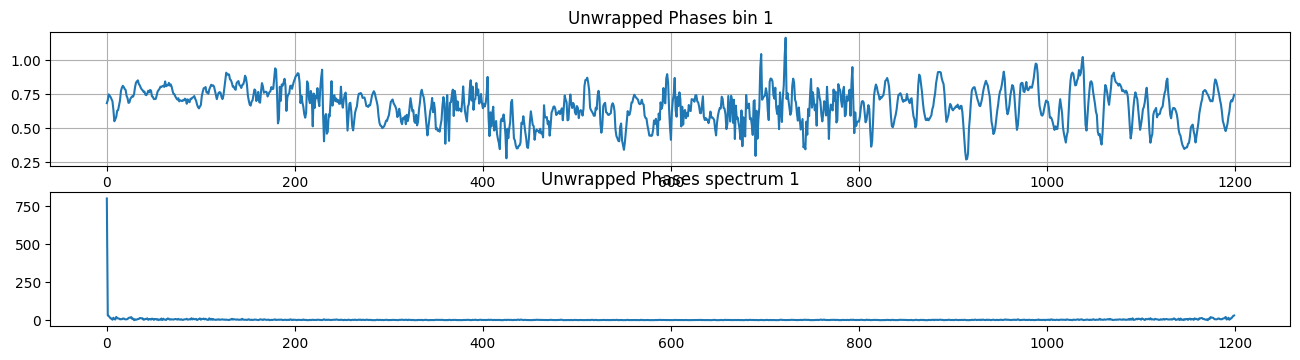

In [51]:
def apply_filter(_signal,_low_cut_freq,_high_cut_freq,_sampling_rate,show_plot,plot_screen_count,plot_index):
       
    order = 4  # Filter order
    # Normalize the cutoff frequencies
    nyquist_freq = 0.5 * _sampling_rate
    low = _low_cut_freq / nyquist_freq
    high = _high_cut_freq / nyquist_freq

    # Apply the bandpass filter
    b, a = butter(order, [low, high], btype='band', fs=_sampling_rate)
    filtered_signal = filtfilt(b, a, _signal)
    filtered_freq_signal = np.fft.fft(filtered_signal)
    filtered_magnitude = np.abs(filtered_freq_signal)
    filtered_freq = np.fft.fftfreq(len(filtered_signal), d=1/_sampling_rate)
    
    positive_filtered_freq = filtered_freq[:len(filtered_freq)//2]  # Consider only the positive frequencies
    positive_filtered_freq_signal = filtered_freq_signal[:len(filtered_freq)//2]
    positive_filtered_magnitude = np.abs(positive_filtered_freq_signal)
    positive_peaks, _ = find_peaks(np.abs(positive_filtered_freq_signal))
    positive_peak_freqs = positive_filtered_freq[positive_peaks]
    positive_peak_magnitudes = filtered_magnitude[positive_peaks]
    
    if(True == show_plot):
        plt.subplot(plot_screen_count,1,plot_index)
        plt.plot(positive_filtered_freq,positive_filtered_magnitude)
        plt.plot(positive_peak_freqs, positive_peak_magnitudes, 'ro', label='Peaks')

        for freq, mag in zip(positive_peak_freqs, positive_peak_magnitudes):
            plt.annotate(f'{freq:.1f}', xy=(freq, mag), xytext=(freq, mag+5))
        
    return filtered_signal

for bin_selected,val in enumerate(magnitude_index):
    if(0!=val):
        ffts_interested_bin = [fft_chirp[bin_selected] for fft_chirp in fft_chirps]
        angles = np.angle(np.array(ffts_interested_bin).flatten())
        # unwrapped_phase = np.unwrap(angles)

        WINDOW_SIZE= 20*60
        WINDOW_ANGLE = angles[0:WINDOW_SIZE]
        unwrapped_phase = np.unwrap(WINDOW_ANGLE)

        plt.figure(figsize=(16,8))
        plt.subplot(4,1,1)
        plt.plot(unwrapped_phase)
        plt.title('Unwrapped Phases bin {0}'.format(bin_selected))
        plt.grid(True)
        
        plt.subplot(4,1,2)
        plt.plot(np.abs(np.fft.fft(unwrapped_phase)))
        plt.title('Unwrapped Phases spectrum {0}'.format(bin_selected))
        

        filtered_singal = apply_filter(unwrapped_phase,0.05,4,20,False,-1,-1)
        apply_filter(filtered_singal,0.84,3.6,20,True,plot_screen_count=4,plot_index=3)
        apply_filter(filtered_singal,0.08,58,20,True,plot_screen_count=4,plot_index=4)
        plt.tight_layout()
        plt.show()


In [ ]:
for i,val in enumerate(magnitude_index):
    if(0!=val):
        bin_of_interest = i
        print("bin selected: ",bin_of_interest)
        ffts_interested_bin = [fft_chirp[bin_of_interest] for fft_chirp in fft_chirps]
        print("ffts_interested_bin shape: ",np.array(ffts_interested_bin).shape)
        angles = np.angle(np.array(ffts_interested_bin).flatten())
        WINDOW_SIZE= 20*60
        WINDOW_ANGLE = angles[0:WINDOW_SIZE]
        unwrapped_phase = np.unwrap(angles)

        plt.figure(figsize=(16,8))
        plt.plot(unwrapped_phase)
        # plt.plot(frequency_domain_signal)
        plt.title('Unwrapped Phases {0}'.format(i))
        plt.grid(True)
        plt.show()


        plt.figure(figsize=(16,8))
        plt.plot(np.abs(np.fft.fft(unwrapped_phase)))
        plt.title('Unwrapped Phases spectrum {0}'.format(i))
        plt.grid(True)
        plt.show()


In [ ]:

def split_signal(_signal,_sample_count):
    parts = np.array_split(_signal,len(_signal)//_sample_count)
    parts_fft = [np.fft.fft(part) for part in parts]
    parts_spectrum = [np.abs(part_fft) for part_fft in parts_fft]
    parts_freq =  [np.fft.fftfreq(len(part),d=1/_sample_count) for part in parts]
    parts_peak = [find_peaks(part_spectrum) for part_spectrum in parts_spectrum]
    return parts


def apply_filter(_signal,_low_cut_freq,_high_cut_freq,_sampling_rate,show_plot):
   
    order = 4  # Filter order
    # Normalize the cutoff frequencies
    nyquist_freq = 0.5 * _sampling_rate
    low = _low_cut_freq / nyquist_freq
    high = _high_cut_freq / nyquist_freq

    # Apply the bandpass filter
    b, a = butter(order, [low, high], btype='band', fs=_sampling_rate)
    filtered_signal = filtfilt(b, a, _signal)
    filtered_freq_signal = np.fft.fft(filtered_signal)
    filtered_magnitude = np.abs(filtered_freq_signal)
    filtered_freq = np.fft.fftfreq(len(filtered_signal), d=1/_sampling_rate)
    
    positive_filtered_freq = filtered_freq[:len(filtered_freq)]  # Consider only the positive frequencies
    positive_filtered_freq_signal = filtered_freq_signal[:len(filtered_freq)]
    positive_filtered_magnitude = np.abs(positive_filtered_freq_signal)
    positive_peaks, _ = find_peaks(np.abs(positive_filtered_freq_signal))
    positive_peak_freqs = positive_filtered_freq[positive_peaks]
    positive_peak_magnitudes = filtered_magnitude[positive_peaks]
    
    if(True == show_plot):
        plt.figure(figsize=(16, 8))
        plt.plot(positive_filtered_freq,positive_filtered_magnitude)
        plt.plot(positive_peak_freqs, positive_peak_magnitudes, 'ro', label='Peaks')

        for freq, mag in zip(positive_peak_freqs, positive_peak_magnitudes):
            plt.annotate(f'{freq:.1f}', xy=(freq, mag), xytext=(freq, mag+5))
        
    return filtered_signal


for i,val in enumerate(magnitude_index):
    if(0!=val):
        bin_of_interest = i

signal_parts =split_signal(unwrapped_phase,20*60)#each 1 minute
for signal_part in signal_parts:
    plt.plot(signal_part)
#filtered_signal_parts = [apply_filter(signal_part,0.05,4,20,False) for signal_part in signal_parts]

# for filtered_signal_part in filtered_signal_parts:
#     filtered_breath_signal = apply_filter(filtered_signal_part,0.08,0.58,20,False)
#     plt.plot(filtered_signal_part)
#     break





In [ ]:
print(unwrapped_phase.shape)
FPS=20*60
#each part is one second ~= 20 frame ~= 20 chirp
parts = np.array_split(unwrapped_phase,len(unwrapped_phase)//FPS)
part_freq_signals = [np.fft.fft(part) for part in parts]
part_spectrums = [np.abs(part_freq_signal) for part_freq_signal in part_freq_signals]
part_freqs =  [np.fft.fftfreq(len(part),d=1/FPS) for part in parts]

# part_peaks_index,_ = [find_peaks(part_spectrum) for part_spectrum in part_spectrums] 
part_peaks_index,_ = find_peaks(part_spectrums[0])

print(np.array(part_spectrums).shape)
plt.figure(figsize=(12, 6))
plt.plot(part_freqs[0],np.abs(part_freq_signals[0]))
# plt.plot(part_freqs[1],np.abs(part_freq_signals[1]))
peak_frequencies = (part_freqs[0])[part_peaks_index[0]]
yyy=np.abs((part_freq_signals[0])[part_peaks_index[0]])
plt.plot(peak_frequencies, yyy, 'ro', label='Peaks')

# plt.imshow(part_spectrum, cmap='jet', aspect='auto')
# plt.colorbar()
plt.show()



In [ ]:
fs = 20  #T_c is sweeptime so sampling rate is 1 sample per sweeptime
lowcut = 0.4  # Lower cutoff frequency of the bandpass filter
highcut = 5  # Upper cutoff frequency of the bandpass filter
order = 4  # Filter order

# Normalize the cutoff frequencies
nyquist_freq = 0.5 * fs
low = lowcut / nyquist_freq
high = highcut / nyquist_freq

# Apply the bandpass filter
b, a = butter(order, [low, high], btype='band', fs=fs)
filtered_phase_change = filtfilt(b, a, unwrapped_phase)

frequency_domain = np.fft.fft(filtered_phase_change)
frequencies = np.fft.fftfreq(len(filtered_phase_change), d=1/fs)
# peaks, _ = find_peaks(np.abs(frequency_domain))
# # Get the peak frequencies
# peak_frequencies = frequencies[peaks]

positive_frequencies = frequencies[:len(frequencies)//2]  # Consider only the positive frequencies
positive_frequency_domain = frequency_domain[:len(frequencies)//2]  # Corresponding positive frequency domain signal

peaks, _ = find_peaks(np.abs(positive_frequency_domain))

# Get the peak frequencies in the positive frequency range
peak_frequencies = positive_frequencies[peaks]

peak_bpm = peak_frequencies 

print(np.array(filtered_phase_change).shape)
plt.figure(figsize=(12, 6))
# plt.plot(filtered_phase_change)
plt.plot(frequencies, np.abs(frequency_domain))
plt.plot(peak_frequencies, np.abs(frequency_domain[peaks]), 'ro')
for i, freq in enumerate(peak_frequencies):
    bpm =  freq*60
    plt.annotate(f'{bpm:.2f} bpm', (freq, np.abs(positive_frequency_domain[peaks[i]])),
                 xytext=(5, 10), textcoords='offset points', color='blue')

# for i, bpm in enumerate(peak_bpm):
    
#     plt.annotate(f'{bpm :.2f} BPM', (peak_frequencies[i], np.abs(positive_frequency_domain[peaks[i]])),
#                  xytext=(5, 10), textcoords='offset points', color='blue')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Signal with Peaks')
plt.grid(True)

plt.show()
